In [2]:
import numpy as np
import networkx as nx
import community as community_louvain  # 正确的导入方式
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from helper_util import *
import seaborn as sns
from helper_simulation import expand_data_df
current_date = datetime.now().strftime("%Y%m%d")    
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline


max_id=get_max("exp_result")
log_path=f"exp_result/{str(max_id)}.{current_date}.Clustering"

logger=get_logger(log_path)

/home/jianj0c/anaconda3/envs/py3-env/lib/python3.7/site-packages/tigramite/independence_tests/gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/jianj0c/anaconda3/envs/py3-env/lib/python3.7/site-packages/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))


exp_result/284.20250322.Clustering/xx.log


In [3]:
from helper_util import *

all_assets=[]
for category in categories:
    all_assets.extend(categories[category])
all_assets=sorted(all_assets)
var_names=np.array([f"${i}^{{u}}$" for i in all_assets]+[f"${i}^{{l}}$" for i in all_assets]+[f"${i}.vol$" for i in all_assets])

In [4]:

import pickle



path="/home/jianj0c/project/STP/code_publish/tailSCM/exp_result/280.20250321.applicationChinaDerivatives_I600/whole_market_results_detail0.01_q0.5.pkl"
path="/home/jianj0c/project/STP/code_publish/tailSCM/exp_result/280.20250321.applicationChinaDerivatives_I600/whole_market_results_detail0.005_q0.5.pkl"
path="/home/jianj0c/project/STP/code_publish/tailSCM/exp_result/280.20250321.applicationChinaDerivatives_I600/whole_market_results_detail0.01_q1.pkl"
path="/home/jianj0c/project/STP/code_publish/tailSCM/exp_result/282.20250321.applicationChinaDerivatives_I600/whole_market_results_detail0.01_q1.pkl"
pc_alpha=float(path.split("/")[-1].split("_")[-2][6:])
quantile=float(path.split("/")[-1].split("_")[-1][1:-4])
details=pickle.load(open(path,"rb"))
strength=details["val_matrix"]
p_value=details["p_matrix"]


adjacency_matrix=np.zeros(shape=(len(var_names),len(var_names)))

adjacency_matrix[p_value[:,:,0]<pc_alpha]=strength[:,:,0][p_value[:,:,0]<pc_alpha]

In [5]:
new_adjacency_matrix=np.zeros(shape=(len(all_assets),len(all_assets)))
for i in range(len(all_assets)):
    for j in range(len(all_assets)):
        if i!=j:
            new_adjacency_matrix[i,j]=adjacency_matrix[[i,i+len(all_assets),i+2*len(all_assets)],[j,j+len(all_assets),j+2*len(all_assets)]].mean()
            


/home/jianj0c/anaconda3/envs/py3-env/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


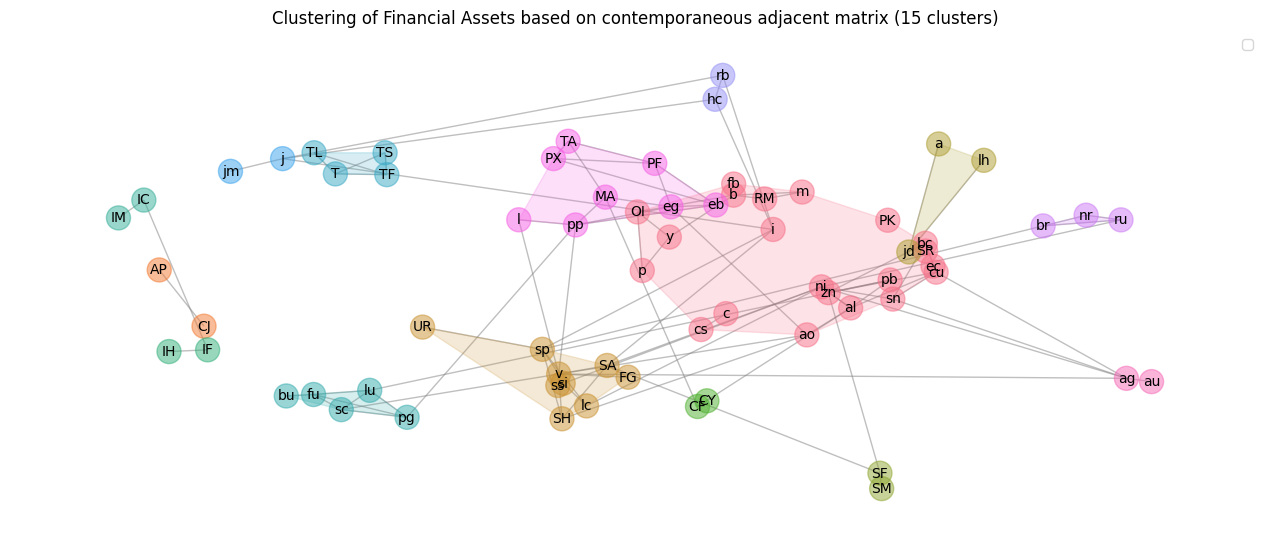

In [66]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from collections import defaultdict
from scipy.spatial import ConvexHull
from adjustText import adjust_text

# ------------------- 1. 进行聚类 -------------------
# 构建图
G = nx.from_numpy_matrix(new_adjacency_matrix)

# 设定簇数
n_clusters = 15
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=43)
labels = sc.fit_predict(new_adjacency_matrix)

# 颜色映射
palette = sns.color_palette("husl", n_clusters)  # 让颜色更分散
node_colors = [palette[labels[i] % len(palette)] for i in range(len(G.nodes))]

# 统计每个类别的资产
cluster_dict = defaultdict(list)
for idx, cluster_id in enumerate(labels):
    cluster_dict[cluster_id].append(idx)

# ------------------- 2. 计算类别间的连接强度 -------------------
# 生成新的加权图
cluster_graph = nx.Graph()

for c1 in cluster_dict:
    for c2 in cluster_dict:
        if c1 != c2:
            weight = np.mean(new_adjacency_matrix[np.ix_(cluster_dict[c1], cluster_dict[c2])])
            if weight > 0:
                cluster_graph.add_edge(c1, c2, weight=weight)

# ------------------- 3. 可视化优化 -------------------
plt.figure(figsize=(12.5, 5))

# **使用 spring_layout，但让同类节点靠近**

pos = nx.spring_layout(G, seed=19,k=0.3)  # `k=0.1` 让节点更聚拢

centralized=0.7
# **增加吸引力，让同类节点更集中**
for cluster_id, node_ids in cluster_dict.items():
    cluster_center = np.mean([pos[n] for n in node_ids], axis=0)  # 计算类别中心
    for node_id in node_ids:
        pos[node_id] = (1-centralized) * pos[node_id] + centralized * cluster_center  # 让节点更接近中心

# **绘制网络**
nx.draw(G, pos, node_color=node_colors, node_size=300, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={i: all_assets[i] for i in range(len(all_assets))}, font_size=10, font_color="black")

# **画社区包围圈**
legend_added = set()  # 用于跟踪已添加的图例
for cluster_id, node_ids in cluster_dict.items():

    plt.plot([], [], color=palette[cluster_id], alpha=0.4)#, label=f"Cluster {cluster_id}")
    legend_added.add(cluster_id)
    if len(node_ids) > 2:  # 只有大于 2 个节点的类别才使用凸包
        points = np.array([pos[n] for n in node_ids])
        hull = ConvexHull(points)
        hull_points = points[hull.vertices, :]
        plt.fill(hull_points[:, 0], hull_points[:, 1], alpha=0.2, color=palette[cluster_id])#, label=f"Cluster {cluster_id}")
        legend_added.add(cluster_id)
    # else:  # 对于少于3个节点的类别，仍然添加到图例中
plt.title(f"Clustering of Financial Assets based on contemporaneous adjacent matrix ({n_clusters} clusters)")
plt.legend()
plt.show()


- the category is: 

    | Category            | Codes                           |
    |---------------------|---------------------------------|
    | Oil Crops           | a, m, OI, p, b, RM, y           |
    | Precious Metals     | ag, au                          |
    | Nonferrous Metals   | al, bc, cu, ni, pb, sn, zn, ao  |
    | Economic Crops      | AP, CF, CJ, CY, PK, SR          |
    | Rubber & Woods      | br, fb, nr, ru, sp              |
    | Oil & Gas           | bu, fu, lu, pg, sc              |
    | Grains              | c, cs                           |
    | Olefins             | eb, l, pp, v                    |
    | Alcohols            | eg, MA                          |
    | Inorganics          | FG, SA, UR, SH                  |
    | Ferrous Metals      | hc, i, rb, SF, SM, ss           |
    | Equity Index        | IC, IF, IH, IM                  |
    | Coals               | j, jm                           |
    | Animals             | jd, lh                          |
    | Novel Materials     | lc, si                          |
    | Aromatics           | PF, TA, PX                      |
    | Interest Rates      | T, TF, TL, TS                   |
    | Indices             | ec                              |